<a href="https://colab.research.google.com/github/YujiOka/LogisticRegression_with_Pytorch/blob/master/73.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import snowballstemmer
import torch

def load_file(filename):
  with open(filename, mode="r", encoding="cp1252") as f:
    lines = f.readlines()
  return lines

In [0]:
class Separation(object):
  def __init__(self):
    # 素性辞書の読み込み
    self.features = load_file("/content/drive/My Drive/feature.txt")
    self.stemmer = snowballstemmer.stemmer("english")
    self.stop_words = (
    "a,about,above,across,after,again,against,all,allmost,alone,along,already,also,although,always,am,among,amount,an,and,another,any,are,around,"
    "as,at,back,be,because,been,but,before,behind,being,between,beyond,bill,by,can,could,cry,detail,do,does,down,due,during,each,eight,either,eleven,else,empty,"
    "etc,ever,every,except,few,fifteen,fifty,find,fire,first,five,for,forty,four,from,front,full,further,get,give,go,had,has,have,he,her,herself,here,"
    "himself,his,how,however,hundred,if,in,inc,indeed,into,is,it,it's,its,itself,keep,last,latter,least,less,ltd,many,may,me,meanwhile,might,mill,mine,more,"
    "moreover,most,much,must,my,myself,name,neither,never,nevertheress,next,nine,no,nobody,none,noone,nor,not,nothing,now,of,off,often,on,once,one,only,"
    "or,other,others,otherwise,our,ours,ourselves,out,over,own,part,per,perhaps,please,rather,re,same,seem,seemed,seeming,seems,serious,several,she,should"
    "show,side,since,sincere,six,sixty,so,some,somehow,someone,something,sometime,sometimes,somewhere,still,such,system,take,ten,than,that,the,their,them,"
    "themselves,then,there,thereby,therefore,these,they,thick,thin,third,this,those,though,three,through,throughout,thus,to,together,too,top,toward,towaeds,"
    "twelve,twenty,two,under,until,up,upon,us,very,via,was,we,well,were,what,whatever,when,whenever,where,wherever,whether,which,while,who,whoever,who,whoever,"
    "whole,whom,whose,why,will,with,within,would,yet,you,your,yours,yourself,yourselves,the,"
    ).lower().split(",")

  def __len__(self):
    return len(self.features)
  
  def stopword(self, str):
    return str.lower() in self.stop_words
  
  def make_bow_vector(self, sentence):
    vec = torch.zeros(len(self.features))
    sentence = sentence.split(" ")
    for word in sentence:
      # ストップワード除去
      if self.stopword(word):
        continue
      # ステミング
      word = self.stemmer.stemWord(word)
      if word in self.features:
        vec[self.features.index(word)] += 1
    return vec
  
  def __call__(self, sample):
    if sample[:2] == "+1":
      label = torch.Tensor([0, 1])
    else:
      label = torch.Tensor([1, 0])
    
    return self.make_bow_vector(sample[3:]), label

In [0]:
# word2vecの作成
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, transform=None):
    self.transform = transform
    # データセットの元文
    self.lines = load_file("/content/drive/My Drive/sentiment.txt")

  def __len__(self):
    return len(self.lines)
    
  def __getitem__(self, index):
    data, label = self.transform(self.lines[index])
    return data, label

In [0]:
class Logistic(torch.nn.Module):
  def __init__(self, vocab_num, batch_size):
    super(Logistic,self).__init__()
    self.linear = torch.nn.Linear(vocab_num, 2)
    self.sigmoid = torch.nn.Sigmoid()
    
  def forward(self, x):
    x = self.linear(x)
    return self.sigmoid(x)

epoch: 1 , loss: 241.699539
epoch: 2 , loss: 241.196503
epoch: 3 , loss: 240.719269
epoch: 4 , loss: 240.267319
epoch: 5 , loss: 239.840210
epoch: 6 , loss: 239.436157
epoch: 7 , loss: 239.057510
epoch: 8 , loss: 238.699295
epoch: 9 , loss: 238.363007
epoch: 10 , loss: 238.046844


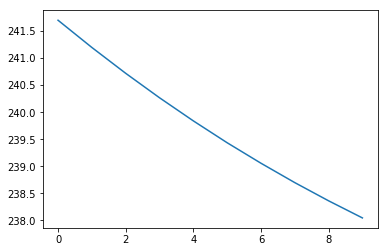

In [8]:
transform = Separation()
dataset = MyDataset(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
net = Logistic(len(transform), 32).to("cuda")

loss_fn = torch.nn.BCEWithLogitsLoss()
 
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
 
losses = []
 
for epoch in range(10):
  all_loss = 0
  for batch in dataloader:
    optimizer.zero_grad()
    y_pred = net(batch[0].to("cuda"))

    loss = loss_fn(y_pred, batch[1].to("cuda"))
    all_loss += loss
    loss.backward()

    optimizer.step()
    

  print("epoch: %d , loss: %f" % (epoch+1, all_loss))
  losses.append(all_loss.item())

  if(epoch != 0):
      if(abs(losses[epoch-1] - losses[epoch]) < 0.00001):
          break

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(losses)
plt.savefig('losses.png')
plt.show()

In [7]:
torch.cuda.is_available()

True